# Term Project 3

In [20]:
import numpy as np
import math
from math import log
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt

In [21]:
# Set random seed for reproducibility
np.random.seed(1234)  
T = 100  # length of time series
phi_true = 0.9                 # true AR(1) coefficient
alpha_true = 1.5               # true measurement coefficient
sigma2_true = 0.1              # true process noise variance
tau2_true = 0.2                # true measurement noise variance

# Initialize arrays
x_true = np.zeros(T)
y_obs  = np.zeros(T)

# Initial state x_0 
x_true[0] = np.random.normal(0, np.sqrt(sigma2_true/(1-phi_true**2)))
y_obs[0]  = alpha_true * x_true[0] + np.random.normal(0, np.sqrt(tau2_true))

# Simulate forward
for t in range(1, T):
    x_true[t] = phi_true * x_true[t-1] + np.random.normal(0, np.sqrt(sigma2_true))
    y_obs[t]  = alpha_true * x_true[t] + np.random.normal(0, np.sqrt(tau2_true))

# Display first few data points
print("First 5 true states:", x_true[:5])
print("First 5 observations:", y_obs[:5])

First 5 true states: [0.34201501 0.76087524 0.45691755 0.68305152 0.61970999]
First 5 observations: [-0.019598    1.00149068  1.08212765  0.73991531 -0.07339421]


In [22]:
def particle_filter(y_observations, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2, N=1000):
    T = len(y_observations)
    # Initialize particles from prior (assume prior ~ N(0, steady-state variance))
    if phi**2 < 1:
        init_var = sigma2 / (1 - phi**2)
    else:
        init_var = sigma2 * 10  # arbitrary large variance if non-stationary
    particles = np.random.normal(0, np.sqrt(init_var), size=N)
    weights = np.ones(N) / N  # start with equal weights

    state_estimates = np.zeros(T)
    # Update weights with first observation y0
    diff0 = y_observations[0] - alpha * particles       # innovation for each particle
    likelihoods = (1/np.sqrt(2*np.pi*tau2)) * np.exp(-0.5 * (diff0**2) / tau2)
    weights *= likelihoods
    weights /= np.sum(weights)                          # normalize weights
    state_estimates[0] = np.sum(weights * particles)    # weighted mean estimate

    # Resample particles based on weights
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    particles = particles[indices]
    weights.fill(1.0/N)  # reset weights to uniform after resampling

    # Iterate through time steps 1 to T-1
    for t in range(1, T):
        # Prediction: propagate each particle according to state model
        particles = phi * particles + np.random.normal(0, np.sqrt(sigma2), size=N)
        # Update: weight particles by likelihood of observation y[t]
        diff = y_observations[t] - alpha * particles
        likelihoods = (1/np.sqrt(2*np.pi*tau2)) * np.exp(-0.5 * (diff**2) / tau2)
        weights *= likelihoods
        weights /= np.sum(weights)                      # normalize
        state_estimates[t] = np.sum(weights * particles)
        # Resample
        indices = np.random.choice(np.arange(N), size=N, p=weights)
        particles = particles[indices]
        weights.fill(1.0/N)
    return state_estimates

# Run particle filter on the simulated data
x_pf_est = particle_filter(y_obs, phi=phi_true, alpha=alpha_true, sigma2=sigma2_true, tau2=tau2_true, N=1000)

In [23]:
# Compute PF estimation error
pf_errors = x_pf_est - x_true
print("Particle Filter RMSE:", np.sqrt(np.mean(pf_errors**2)))

Particle Filter RMSE: 0.26306123758589933


In [24]:
def kalman_filter(y_observations, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2):
    """
    Kalman Filter for state estimation in a linear Gaussian model.
    Returns arrays of filtered state means and variances.
    """
    T = len(y_observations)
    x_est = np.zeros(T)
    P_est = np.zeros(T)
    # Initialize prior for x_0
    x_est[0] = 0.0
    P_est[0] = sigma2/(1-phi**2) if phi**2 < 1 else sigma2 * 10  # large prior var if not stationary
    K0 = P_est[0] * alpha / (alpha**2 * P_est[0] + tau2)
    x_est[0] = x_est[0] + K0 * (y_observations[0] - alpha * x_est[0])
    P_est[0] = (1 - K0 * alpha) * P_est[0]
    # Iterate for t=1...T-1
    for t in range(1, T):
        # Prediction
        x_pred = phi * x_est[t-1]
        P_pred = phi**2 * P_est[t-1] + sigma2
        # Update 
        Kt = P_pred * alpha / (alpha**2 * P_pred + tau2)
        x_est[t] = x_pred + Kt * (y_observations[t] - alpha * x_pred)
        P_est[t] = (1 - Kt * alpha) * P_pred
    return x_est, P_est

x_kf_est, P_kf_est = kalman_filter(y_obs, phi=phi_true, alpha=alpha_true, sigma2=sigma2_true, tau2=tau2_true)
print("Kalman Filter RMSE:", np.sqrt(np.mean((x_kf_est - x_true)**2)))

Kalman Filter RMSE: 0.2611220924878127


In [25]:
def neg_log_likelihood(params, observations):
    phi, alpha, log_sigma2, log_tau2 = params
    sigma2 = math.exp(log_sigma2)
    tau2   = math.exp(log_tau2)
    T = len(observations)
    # initialize
    x_mean = 0.0
    P_var = sigma2/(1-phi**2) if phi**2 < 1 else sigma2*100  # large prior var if needed
    logL = 0.0
    for t in range(T):
        # Prediction (for t=0, prediction is prior)
        # Compute innovation and its variance
        S = alpha**2 * P_var + tau2
        nu = observations[t] - alpha * x_mean
        # Update log-likelihood
        logL += -0.5*(math.log(2*math.pi*S) + (nu**2)/S)
        # Kalman update
        K = (P_var * alpha) / S
        x_mean = x_mean + K * nu
        P_var = (1 - K*alpha) * P_var
        # Predict next (except at last step)
        if t < T-1:
            x_mean = phi * x_mean
            P_var = phi**2 * P_var + sigma2
    return -logL  # return negative log-likelihood for min

# Initial guess for parameters
initial_guess = [0.5, 1.0, log(0.1), log(0.2)]
result = minimize(neg_log_likelihood, initial_guess, args=(y_obs,))
phi_est, alpha_est, log_sigma2_est, log_tau2_est = result.x
sigma2_est = math.exp(log_sigma2_est)
tau2_est   = math.exp(log_tau2_est)

print("Estimated phi =", round(phi_est, 3))
print("Estimated alpha =", round(alpha_est, 3))
print("Estimated sigma^2 =", round(sigma2_est, 3))
print("Estimated tau^2 =", round(tau2_est, 3))

Estimated phi = 0.959
Estimated alpha = 4.346
Estimated sigma^2 = 0.004
Estimated tau^2 = 0.298


In [26]:
# State estimation using Kalman smoother with estimated parameters
x_kf_est_MLE, P_kf_est_MLE = kalman_filter(y_obs, phi=phi_est, alpha=alpha_est, sigma2=sigma2_est, tau2=tau2_est)
# (We reuse the kalman_filter function; it returns the filtered estimates.)
# Now perform Rauch-Tung-Striebel smoothing on the filtered results:
def kalman_smoother(x_filt, P_filt, phi, alpha, sigma2, tau2):
    T = len(x_filt)
    x_smooth = np.copy(x_filt)
    # Backward smoothing
    for t in range(T-2, -1, -1):
        # Compute smoothing gain
        P_pred = phi**2 * P_filt[t] + sigma2    # prior var at t+1
        G = P_filt[t] * phi / P_pred
        # Smooth the state estimate
        x_smooth[t] += G * (x_smooth[t+1] - phi * x_filt[t])
    return x_smooth

x_mle_smooth = kalman_smoother(x_kf_est_MLE, P_kf_est_MLE, phi=phi_est, alpha=alpha_est, sigma2=sigma2_est, tau2=tau2_est)
print("MLE-based method RMSE:", np.sqrt(np.mean((x_mle_smooth - x_true)**2)))

MLE-based method RMSE: 0.5326021386548989



Noise type: gaussian
PF RMSE: 0.2319
KF RMSE: 0.2318
RMSE Ratio (KF/PF): 0.9994

Particle Filter Parameter Estimates:
phi: True=0.9000, Est=0.9067, Error=0.0067, %Error=0.75%
alpha: True=1.5000, Est=1.6770, Error=0.1770, %Error=11.80%
sigma2: True=0.1000, Est=0.0783, Error=-0.0217, %Error=21.69%
tau2: True=0.2000, Est=0.0549, Error=-0.1451, %Error=72.53%

Kalman Filter Parameter Estimates:
phi: True=0.9000, Est=0.9062, Error=0.0062, %Error=0.69%
alpha: True=1.5000, Est=1.6735, Error=0.1735, %Error=11.57%
sigma2: True=0.1000, Est=0.0791, Error=-0.0209, %Error=20.91%
tau2: True=0.2000, Est=0.0537, Error=-0.1463, %Error=73.17%

MLE Parameter Estimates:
phi: True=0.9000, Est=0.9245, Error=0.0245, %Error=2.72%
alpha: True=1.5000, Est=3.7129, Error=2.2129, %Error=147.52%
sigma2: True=0.1000, Est=0.0102, Error=-0.0898, %Error=89.81%
tau2: True=0.2000, Est=0.2184, Error=0.0184, %Error=9.20%


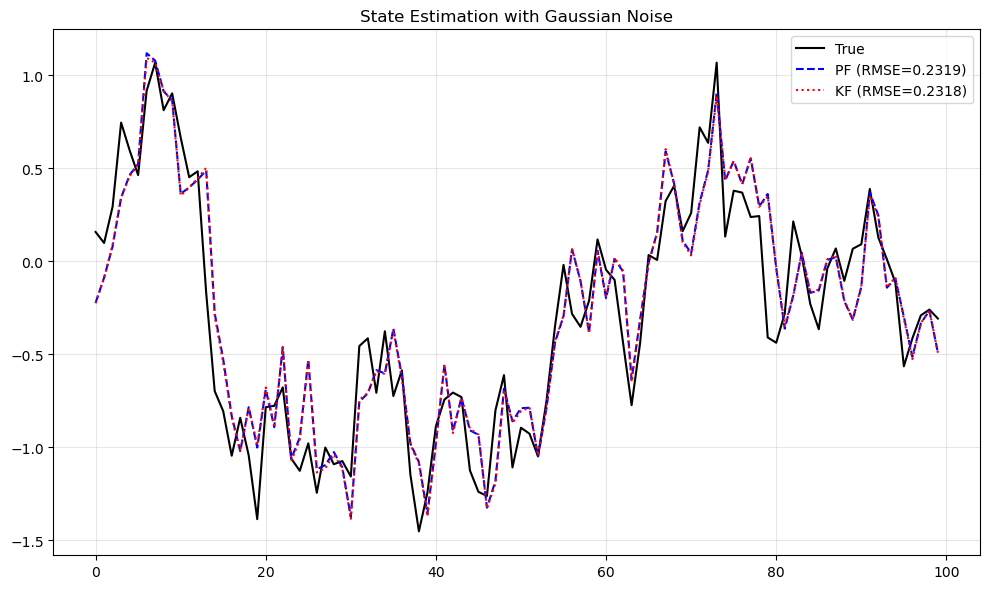


Noise type: t
PF RMSE: 0.3349
KF RMSE: 0.3280
RMSE Ratio (KF/PF): 0.9795

Particle Filter Parameter Estimates:
phi: True=0.9000, Est=0.8910, Error=-0.0090, %Error=1.00%
alpha: True=1.5000, Est=1.6639, Error=0.1639, %Error=10.93%
sigma2: True=0.1000, Est=0.1178, Error=0.0178, %Error=17.76%
tau2: True=0.2000, Est=0.0763, Error=-0.1237, %Error=61.86%

Kalman Filter Parameter Estimates:
phi: True=0.9000, Est=0.8938, Error=-0.0062, %Error=0.69%
alpha: True=1.5000, Est=1.6666, Error=0.1666, %Error=11.10%
sigma2: True=0.1000, Est=0.1146, Error=0.0146, %Error=14.65%
tau2: True=0.2000, Est=0.0790, Error=-0.1210, %Error=60.50%

MLE Parameter Estimates:
phi: True=0.9000, Est=0.9125, Error=0.0125, %Error=1.39%
alpha: True=1.5000, Est=3.9228, Error=2.4228, %Error=161.52%
sigma2: True=0.1000, Est=0.0162, Error=-0.0838, %Error=83.81%
tau2: True=0.2000, Est=0.2891, Error=0.0891, %Error=44.57%


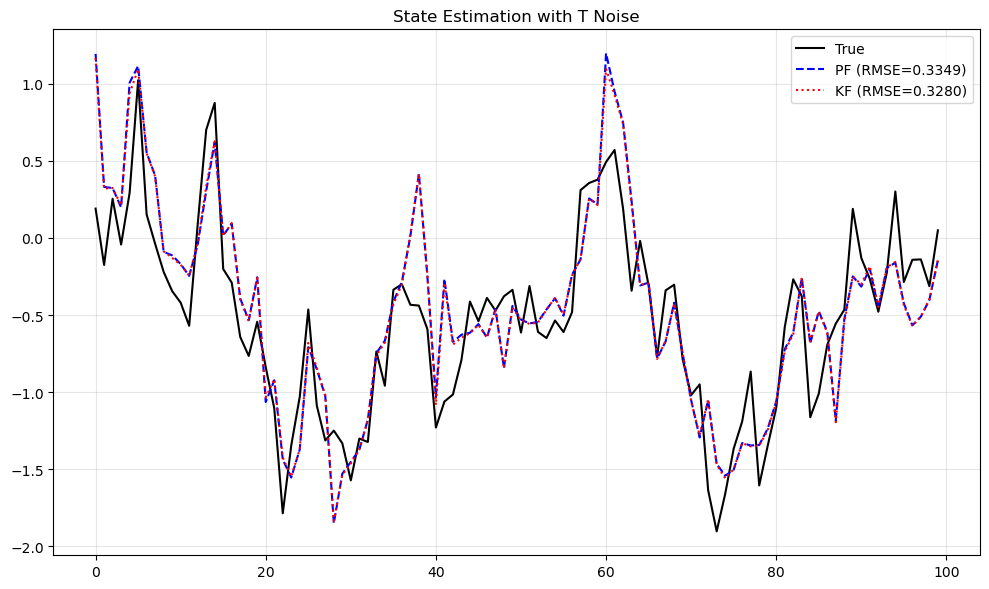


Noise type: bimodal
PF RMSE: 0.2501
KF RMSE: 0.1622
RMSE Ratio (KF/PF): 0.6488

Particle Filter Parameter Estimates:
phi: True=0.9000, Est=0.8536, Error=-0.0464, %Error=5.15%
alpha: True=1.5000, Est=1.8321, Error=0.3321, %Error=22.14%
sigma2: True=0.1000, Est=0.8027, Error=0.7027, %Error=702.70%
tau2: True=0.2000, Est=1.0969, Error=0.8969, %Error=448.43%

Kalman Filter Parameter Estimates:
phi: True=0.9000, Est=0.8317, Error=-0.0683, %Error=7.59%
alpha: True=1.5000, Est=1.7291, Error=0.2291, %Error=15.28%
sigma2: True=0.1000, Est=1.0704, Error=0.9704, %Error=970.44%
tau2: True=0.2000, Est=0.7288, Error=0.5288, %Error=264.42%

MLE Parameter Estimates:
phi: True=0.9000, Est=0.7383, Error=-0.1617, %Error=17.97%
alpha: True=1.5000, Est=0.7680, Error=-0.7320, %Error=48.80%
sigma2: True=0.1000, Est=7.7225, Error=7.6225, %Error=7622.52%
tau2: True=0.2000, Est=1.0507, Error=0.8507, %Error=425.37%


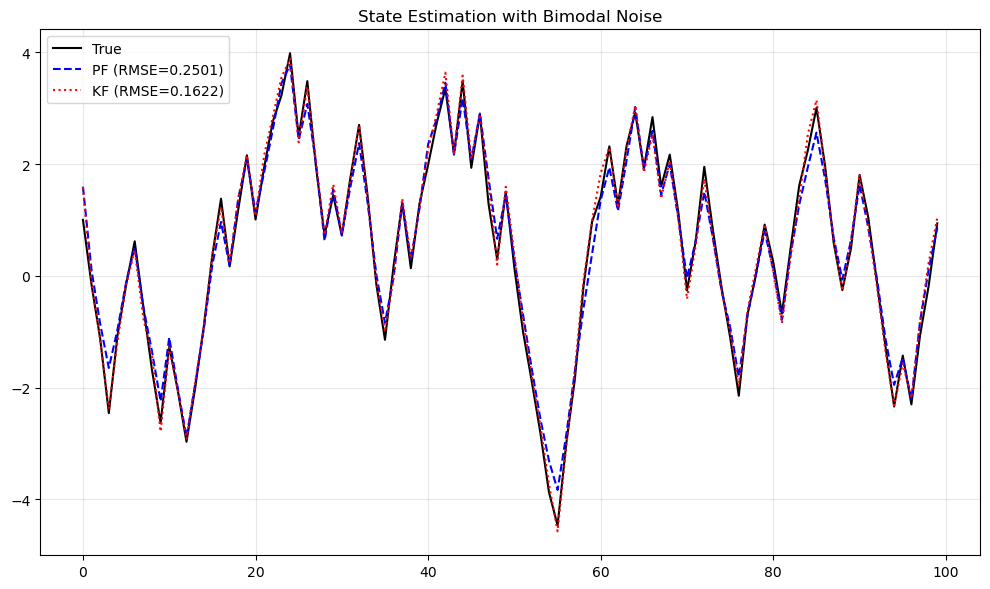


Comparison across noise types:
Noise Type  PF RMSE  KF RMSE  KF/PF Ratio  PF phi Error (%)  KF phi Error (%)  MLE phi Error (%)
  gaussian 0.231926 0.231793     0.999426          0.745443          0.691951           2.723460
         t 0.334853 0.328004     0.979546          0.997199          0.690465           1.391798
   bimodal 0.250057 0.162229     0.648768          5.150025          7.590074          17.969721


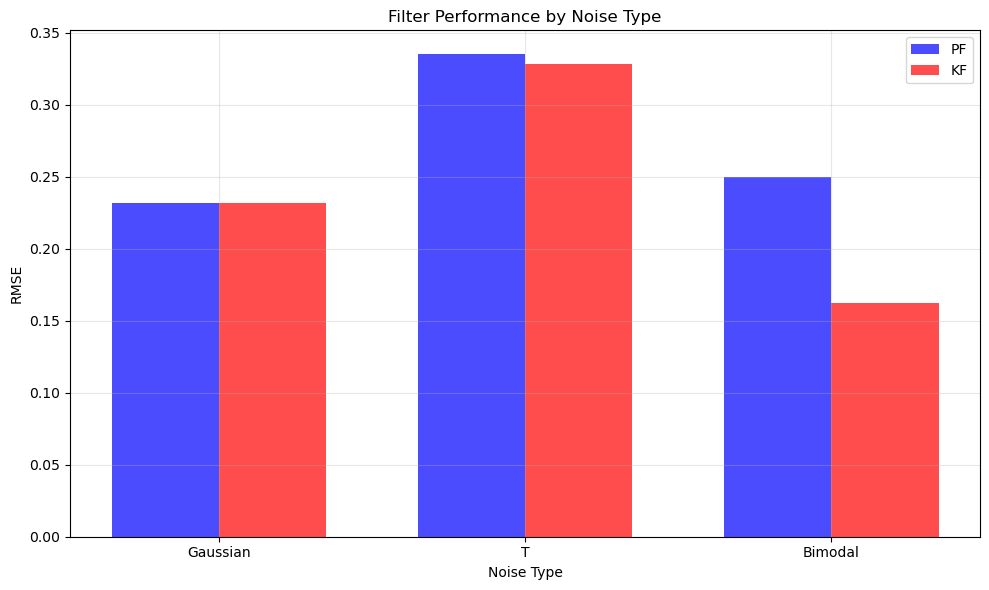

In [33]:
def particle_filter(y_obs, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2, N=1000):
   """Particle filter implementation"""
   T = len(y_obs)
   
   # Initialize particles from prior
   particles = np.random.normal(0, np.sqrt(sigma2/(1-phi**2)), size=N)
   weights = np.ones(N) / N  # start with equal weights
   
   state_estimates = np.zeros(T)
   
   # Update weights with first observation
   diff0 = y_obs[0] - alpha * particles
   likelihoods = np.exp(-0.5 * (diff0**2) / tau2) / np.sqrt(2*np.pi*tau2)
   weights *= likelihoods
   weights /= np.sum(weights)  # normalize weights
   state_estimates[0] = np.sum(weights * particles)
   
   # Resample particles
   indices = np.random.choice(np.arange(N), size=N, p=weights)
   particles = particles[indices]
   weights.fill(1.0/N)  # reset weights
   
   # Iterate through time steps 1 to T-1
   for t in range(1, T):
       # Prediction step
       particles = phi * particles + np.random.normal(0, np.sqrt(sigma2), size=N)
       
       # Update step
       diff = y_obs[t] - alpha * particles
       likelihoods = np.exp(-0.5 * (diff**2) / tau2) / np.sqrt(2*np.pi*tau2)
       weights *= likelihoods
       weights /= np.sum(weights)  # normalize
       
       # State estimate
       state_estimates[t] = np.sum(weights * particles)
       
       # Resample
       indices = np.random.choice(np.arange(N), size=N, p=weights)
       particles = particles[indices]
       weights.fill(1.0/N)
   
   # Calculate parameter estimates
   # Estimate phi using regression
   X = state_estimates[:-1].reshape(-1, 1)
   y = state_estimates[1:]
   phi_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate alpha
   X = state_estimates.reshape(-1, 1)
   y = y_obs
   alpha_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate noise variances
   pred_errors = state_estimates[1:] - phi_est * state_estimates[:-1]
   sigma2_est = np.mean(pred_errors**2)
   
   meas_errors = y_obs - alpha_est * state_estimates
   tau2_est = np.mean(meas_errors**2)
   
   params = {
       'phi': phi_est,
       'alpha': alpha_est,
       'sigma2': sigma2_est,
       'tau2': tau2_est
   }
   
   return state_estimates, params

def kalman_filter(y_obs, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2):
   """Kalman filter implementation"""
   T = len(y_obs)
   x_est = np.zeros(T)
   P_est = np.zeros(T)
   
   # Initialize prior
   x_est[0] = 0.0
   P_est[0] = sigma2/(1-phi**2)  # steady-state variance
   
   # Initial update
   K0 = P_est[0] * alpha / (alpha**2 * P_est[0] + tau2)
   x_est[0] = x_est[0] + K0 * (y_obs[0] - alpha * x_est[0])
   P_est[0] = (1 - K0 * alpha) * P_est[0]
   
   # Iterate for t=1...T-1
   for t in range(1, T):
       # Prediction step
       x_pred = phi * x_est[t-1]
       P_pred = phi**2 * P_est[t-1] + sigma2
       
       # Update step
       Kt = P_pred * alpha / (alpha**2 * P_pred + tau2)
       x_est[t] = x_pred + Kt * (y_obs[t] - alpha * x_pred)
       P_est[t] = (1 - Kt * alpha) * P_pred
   
   # Estimate parameters
   # Estimate phi using regression
   X = x_est[:-1].reshape(-1, 1)
   y = x_est[1:]
   phi_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate alpha
   X = x_est.reshape(-1, 1)
   y = y_obs
   alpha_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate noise variances
   pred_errors = x_est[1:] - phi_est * x_est[:-1]
   sigma2_est = np.mean(pred_errors**2)
   
   meas_errors = y_obs - alpha_est * x_est
   tau2_est = np.mean(meas_errors**2)
   
   params = {
       'phi': phi_est,
       'alpha': alpha_est,
       'sigma2': sigma2_est,
       'tau2': tau2_est
   }
   
   return x_est, params

def neg_log_likelihood(params, observations):
   """Negative log-likelihood function for AR(1) process"""
   phi, alpha, log_sigma2, log_tau2 = params
   sigma2 = np.exp(log_sigma2)
   tau2 = np.exp(log_tau2)
   T = len(observations)
   
   # Initialize
   x_mean = 0.0
   P_var = sigma2/(1-phi**2) if phi**2 < 1 else sigma2*100
   logL = 0.0
   
   for t in range(T):
       # Compute innovation and its variance
       S = alpha**2 * P_var + tau2
       nu = observations[t] - alpha * x_mean
       
       # Update log-likelihood
       logL += -0.5*(np.log(2*np.pi*S) + (nu**2)/S)
       
       # Kalman update
       K = (P_var * alpha) / S
       x_mean = x_mean + K * nu
       P_var = (1 - K*alpha) * P_var
       
       # Predict next
       if t < T-1:
           x_mean = phi * x_mean
           P_var = phi**2 * P_var + sigma2
   
   return -logL  # Return negative for minimization

def mle_estimation(y_obs):
   """Maximum Likelihood Estimation for AR(1) parameters"""
   from scipy.optimize import minimize
   
   # Initial guess [phi, alpha, log(sigma2), log(tau2)]
   initial_guess = [0.5, 1.0, np.log(0.1), np.log(0.2)]
   
   # Minimize negative log-likelihood
   result = minimize(neg_log_likelihood, initial_guess, args=(y_obs,))
   
   # Extract parameters
   phi_est, alpha_est, log_sigma2_est, log_tau2_est = result.x
   sigma2_est = np.exp(log_sigma2_est)
   tau2_est = np.exp(log_tau2_est)
   
   params = {
       'phi': phi_est,
       'alpha': alpha_est,
       'sigma2': sigma2_est,
       'tau2': tau2_est
   }
   
   return params

def parameter_hypothesis_tests(true_params, estimated_params, method_name):
   """Run hypothesis tests on parameter estimates"""
   print(f"\n{method_name} Parameter Estimates:")
   for param, true_val in true_params.items():
       est_val = estimated_params[param]
       error = est_val - true_val
       pct_error = 100 * abs(error) / true_val
       print(f"{param}: True={true_val:.4f}, Est={est_val:.4f}, Error={error:.4f}, %Error={pct_error:.2f}%")
   
def test_non_gaussian_noise(noise_type='t', seed=42):
   """Test filter performance with non-Gaussian noise"""
   import scipy.stats as stats
   
   # Parameters
   T = 100
   phi = 0.9
   alpha = 1.5
   sigma2 = 0.1
   tau2 = 0.2
   
   # Set random seed
   np.random.seed(seed)
   
   # Initialize arrays
   x_true = np.zeros(T)
   y_obs = np.zeros(T)
   
   # Generate process noise
   if noise_type == 'gaussian':
       proc_noise = np.random.normal(0, np.sqrt(sigma2), T)
       meas_noise = np.random.normal(0, np.sqrt(tau2), T)
   elif noise_type == 't':
       df = 3  # degrees of freedom (heavy tails)
       proc_noise = stats.t.rvs(df, scale=np.sqrt(sigma2), size=T)
       meas_noise = stats.t.rvs(df, scale=np.sqrt(tau2), size=T)
   elif noise_type == 'bimodal':
       # Mixture of two Gaussians
       mix = np.random.binomial(1, 0.5, T)
       proc_noise = np.where(mix, np.random.normal(-1, np.sqrt(sigma2/2), T), 
                             np.random.normal(1, np.sqrt(sigma2/2), T))
       meas_noise = np.where(mix, np.random.normal(-1, np.sqrt(tau2/2), T), 
                            np.random.normal(1, np.sqrt(tau2/2), T))
   else:
       raise ValueError(f"Unknown noise type: {noise_type}")
   
   # Initial state
   x_true[0] = proc_noise[0]
   
   # Generate states
   for t in range(1, T):
       x_true[t] = phi * x_true[t-1] + proc_noise[t]
   
   # Generate observations
   y_obs = alpha * x_true + meas_noise
   
   # Run filters
   x_pf, pf_params = particle_filter(y_obs, phi, alpha, sigma2, tau2)
   x_kf, kf_params = kalman_filter(y_obs, phi, alpha, sigma2, tau2)
   mle_params = mle_estimation(y_obs)
   
   # Calculate RMSE
   pf_rmse = np.sqrt(np.mean((x_pf - x_true)**2))
   kf_rmse = np.sqrt(np.mean((x_kf - x_true)**2))
   
   # Print results
   print(f"\nNoise type: {noise_type}")
   print(f"PF RMSE: {pf_rmse:.4f}")
   print(f"KF RMSE: {kf_rmse:.4f}")
   print(f"RMSE Ratio (KF/PF): {kf_rmse/pf_rmse:.4f}")
   
   # True parameters
   true_params = {'phi': phi, 'alpha': alpha, 'sigma2': sigma2, 'tau2': tau2}
   
   # Run parameter tests
   parameter_hypothesis_tests(true_params, pf_params, "Particle Filter")
   parameter_hypothesis_tests(true_params, kf_params, "Kalman Filter")
   parameter_hypothesis_tests(true_params, mle_params, "MLE")
   
   # Plot results
   plt.figure(figsize=(10, 6))
   plt.plot(x_true, 'k-', label='True')
   plt.plot(x_pf, 'b--', label=f'PF (RMSE={pf_rmse:.4f})')
   plt.plot(x_kf, 'r:', label=f'KF (RMSE={kf_rmse:.4f})')
   plt.title(f'State Estimation with {noise_type.capitalize()} Noise')
   plt.legend()
   plt.grid(alpha=0.3)
   plt.tight_layout()
   plt.savefig(f'{noise_type}_noise_comparison.png')
   plt.show()
   
   return {
       'noise_type': noise_type,
       'true_params': true_params,
       'pf_params': pf_params,
       'kf_params': kf_params,
       'mle_params': mle_params,
       'pf_rmse': pf_rmse,
       'kf_rmse': kf_rmse
   }

# Run tests with different noise types
gaussian_results = test_non_gaussian_noise('gaussian')
t_results = test_non_gaussian_noise('t')
bimodal_results = test_non_gaussian_noise('bimodal')

# Compare results across noise types
noise_types = ['gaussian', 't', 'bimodal']
results = [gaussian_results, t_results, bimodal_results]

# Create comparison table
data = []
for res in results:
   data.append({
       'Noise Type': res['noise_type'],
       'PF RMSE': res['pf_rmse'],
       'KF RMSE': res['kf_rmse'],
       'KF/PF Ratio': res['kf_rmse'] / res['pf_rmse'],
       'PF phi Error (%)': 100 * abs(res['pf_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi'],
       'KF phi Error (%)': 100 * abs(res['kf_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi'],
       'MLE phi Error (%)': 100 * abs(res['mle_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi']
   })

comparison_df = pd.DataFrame(data)
print("\nComparison across noise types:")
print(comparison_df.to_string(index=False))

# Plot comparison bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(noise_types))

plt.bar(x - bar_width/2, comparison_df['PF RMSE'], width=bar_width, label='PF', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, comparison_df['KF RMSE'], width=bar_width, label='KF', color='red', alpha=0.7)

plt.xlabel('Noise Type')
plt.ylabel('RMSE')
plt.title('Filter Performance by Noise Type')
plt.xticks(x, [n.capitalize() for n in noise_types])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('noise_comparison.png')
plt.show()

## Estimation of the GDP gap using real data

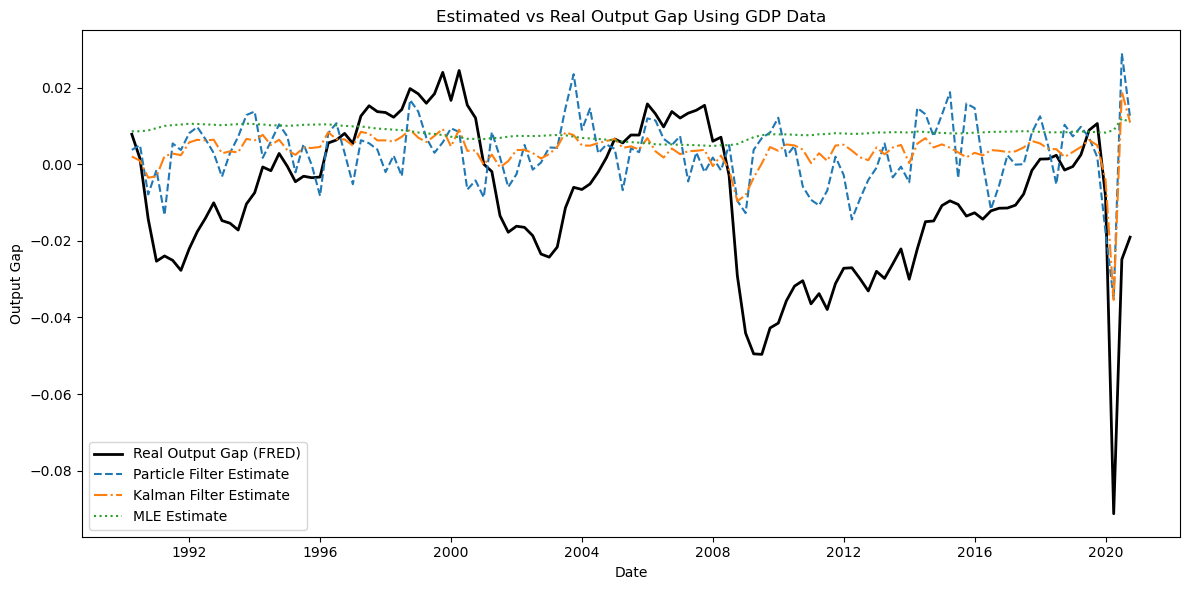

In [27]:
start = datetime(1990, 1, 1)
end   = datetime(2020, 12, 31)

# Download Real GDP (GDPC1) and Potential GDP (GDPPOT) series
gdpc1  = web.DataReader('GDPC1', 'fred', start, end)
gdppot = web.DataReader('GDPPOT', 'fred', start, end)

# Merge and compute the real output gap (as percentage deviation)
df = pd.concat([gdpc1.rename(columns={'GDPC1':'RealGDP'}),
                gdppot.rename(columns={'GDPPOT':'PotentialGDP'})], axis=1).dropna()
df['OutputGap'] = (df['RealGDP'] - df['PotentialGDP']) / df['PotentialGDP']

# Compute GDP growth (log differences)
df['GDP_Growth'] = np.log(df['RealGDP']).diff()
# Drop initial NaN from diff
df = df.dropna()

# Extract observation and "true" state arrays
y_real      = df['GDP_Growth'].values
nx          = len(y_real)
x_true_real = df['OutputGap'].values

# ## Estimate Latent Output Gap using Particle Filter and Kalman Filter
# (Assuming particle_filter and kalman_filter functions and true parameters are defined earlier)
x_pf_real = particle_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true,
                              N=1000)
x_kf_real, p_kf_est = kalman_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true)

x_mle_real = kalman_smoother(x_kf_real, 
                             P_filt = p_kf_est, 
                             phi=phi_est, 
                             alpha=alpha_est, 
                             sigma2=sigma2_est, 
                             tau2=tau2_est)
# ## Plot Estimated vs Real Output Gap

plt.figure(figsize=(12, 6))
plt.plot(df.index, x_true_real, label='Real Output Gap (FRED)', color='black', linewidth=2)
plt.plot(df.index, x_pf_real,   label='Particle Filter Estimate', linestyle='--')
plt.plot(df.index, x_kf_real,   label='Kalman Filter Estimate', linestyle='-.')
plt.plot(df.index, x_mle_real,  label='MLE Estimate', linestyle=':')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Output Gap')
plt.title('Estimated vs Real Output Gap Using GDP Data')
plt.tight_layout()
plt.show()

### Results

The graph illustrates the estimated and real output gap using GDP data over the period from the early 1990s to around 2020. Three lines are presented:

1. Real Output Gap (FRED) - shown as a solid black line.
2. Particle Filter Estimate - shown as a blue dashed line.
3. Kalman Filter Estimate - shown as an orange dash-dot line.

The real output gap exhibits notable fluctuations, especially during significant economic downturns (e.g., the 2008 financial crisis and the COVID-19 pandemic in 2020). The particle and Kalman filter estimates generally track the trend of the real output gap, though with varying levels of volatility.

### Findings

1. **Consistency of Estimates:** The Kalman filter estimate appears smoother and more consistent with long-term trends, while the particle filter estimate shows higher volatility, particularly in periods of economic uncertainty.
2. **Crisis Response:** During major economic shocks, the real output gap diverges significantly from both estimates, particularly during the 2008 financial crisis and the COVID-19 recession. The particle filter estimate shows more rapid and pronounced deviations compared to the Kalman filter.
3. **Post-Crisis Recovery:** Both filter estimates tend to realign with the real output gap after the shock periods, with the Kalman filter demonstrating a more gradual transition compared to the particle filter.

### Discussion

The comparison between the real output gap and the estimated values highlights the trade-offs between filtering methods in terms of volatility and trend alignment. The Kalman filter's smoothness makes it more suitable for long-term economic analysis, while the particle filter's sensitivity may be beneficial for capturing rapid economic shifts. However, the particle filter's heightened volatility may lead to overreacting to short-term variations. Further analysis could involve evaluating the root mean square error (RMSE) of each method against the real gap to quantitatively assess accuracy.
